###**HDBSCAN**

HDBSCAN Algorithm
- Build a minimum spanning tree of distances - Fully Accelerated GPU for for k-nearest neighbors (k-NN) distance graph, mutual reachability graph and minimum spanning tree (MST). GPU-accelerated - cuML.
- Hierarchical Clustering - Optimized for GPUs with parallel processing
- Condense the Hierarchy, dendogram extract - Parallelized on GPU for fast condensation
- Extract Clusters - Cluster selection fully parallelized on GPU
- Convergence - Faster convergence with GPU-based computations

GPU DBSCAN

In [ ]:
# Install cuml library with CUDA 11 support
!pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com > /dev/null/
# Install cudf library with CUDA 11 support
!pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com >/dev/null/
# Then load the cudf.pandas extension
%load_ext cudf.pandas

In [ ]:
import sys, os, shutil
from IPython import get_ipython
import pandas as pd
import cupy as cp
# Install plotly for interactive visualizations
!pip install plotly > /dev/null
!pip install --upgrade scipy scikit-learn > /dev/null

import matplotlib.pyplot as plt

In [ ]:
# Then load the cuml.accel extension
%load_ext cuml.accel

In [ ]:
from sklearn.datasets import make_blobs
from hdbscan import HDBSCAN
from umap import UMAP
from time import time
import plotly.express as px
from sklearn.metrics import silhouette_score

n_samples = 10_000
n_features = 10
n_clusters = 5
random_state = 42

X, _ = make_blobs(
    n_samples=n_samples,
    centers=n_clusters,
    n_features=n_features,
    random_state = random_state
)

X_gpu = cp.asarray(X)

start_time = time()
hdbscan_model = HDBSCAN(min_samples=10, min_cluster_size=100, gen_min_span_tree=True).fit(X_gpu.get())
end_time = time()

labels = cp.asnumpy(hdbscan_model.labels_)
n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
print(f'hdbscan complete in {end_time - start_time}')
print(f'number if clusters {n_clusters}')
print(f'cluster labels (first 10) {labels[:10]}')

hdbscan complete in 0.5384521484375
number if clusters 5
cluster labels (firsr 10) [1 4 0 0 3 4 2 0 1 1]


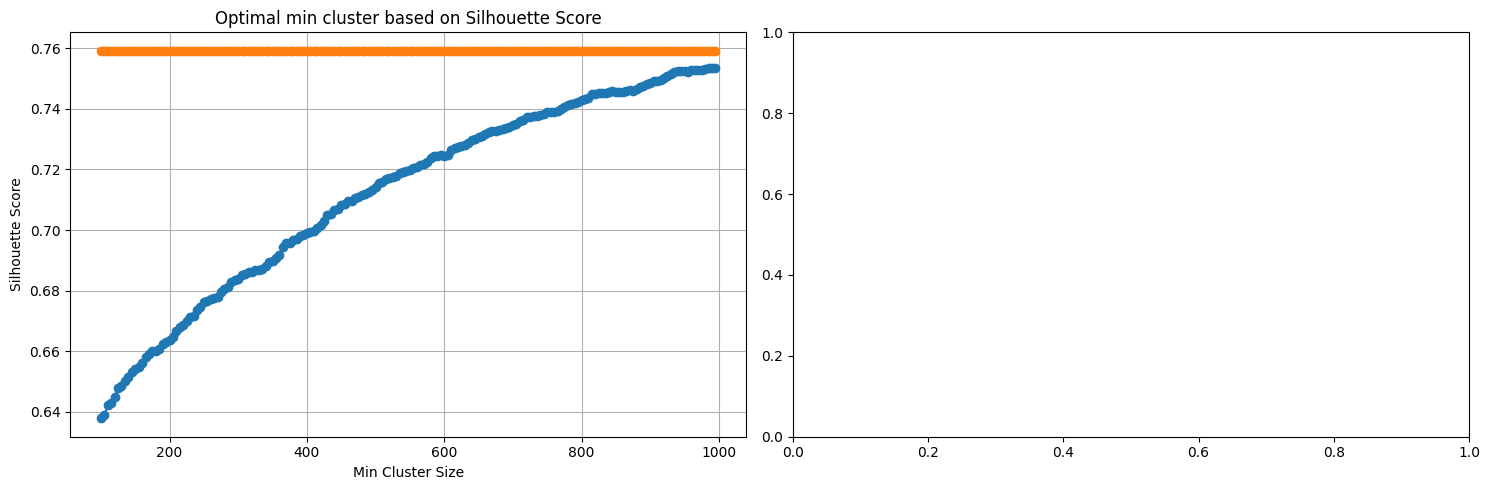

In [ ]:
# try different min cluster size
min_cluster_sizes = range(100, 1000, 5)
persistence_scores, silhouette_scores = [], []

for size in min_cluster_sizes:
    clusterer = HDBSCAN(min_samples=10, min_cluster_size=size, gen_min_span_tree=True)
    clusterer.fit(X_gpu.get())
    p = clusterer.cluster_persistence_
    persistence_scores.append(cp.mean(p).item())
    labels = clusterer.labels_
    s = silhouette_score(X_gpu.get(), labels)
    silhouette_scores.append(s)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(min_cluster_sizes, persistence_scores, marker= 'o', linestyle='-')
ax[0].set_title('Optimal min cluster based on Persistence Score')
ax[0].set_xlabel('Min Cluster Size') ; ax[0].set_ylabel('Persistence Score')
ax[0].grid(True)

ax[0].plot(min_cluster_sizes, silhouette_scores, marker= 'o', linestyle='-')
ax[0].set_title('Optimal min cluster based on Silhouette Score')
ax[0].set_xlabel('Min Cluster Size') ; ax[0].set_ylabel('Silhouette Score')
ax[0].grid(True)
plt.tight_layout() ; plt.show()

In [ ]:
hdbscan = HDBSCAN(min_samples=10, min_cluster_size=200, gen_min_span_tree=True)
hdbscan.fit(X_gpu.get())
umap_3d = UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
embedding_3d = umap_3d.fit_transform(X_gpu.get())
embedding_3d_cpu = cp.asnumpy(embedding_3d)
cluster_labels = hdbscan.labels_
cluster_labels_cpu = cp.asnumpy(cluster_labels)

fig = px.scatter_3d(
    x=embedding_3d_cpu[:, 0],
    y=embedding_3d_cpu[:, 1],
    z=embedding_3d_cpu[:, 2],
    color=cluster_labels_cpu,
    opacity=0.7,
    color_continuous_scale=px.colors.qualitative.Plotly,
    title='HDBSCAN Clustering Results 3D scattering',
    labels={'x': 'Dimension 1', 'y': 'Dimension 2', 'z': 'Dimension 3'}
)
fig.update_traces(marker=dict(size=5))
fig.show()